# EDA AND PREPROCESSING

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
warnings.filterwarnings( 'ignore' )

import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/phmap_train'
file_list = os.listdir(path)
print(file_list)

['train_1st_Bearing.csv', 'train_1st_Looseness.csv', 'train_1st_Normal.csv', 'train_1st_Unbalance.csv', 'train_1st_high.csv', 'train_2nd_Bearing.csv', 'train_2nd_Looseness.csv', 'train_2nd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_3rd_Unbalance.csv']


In [69]:
def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))-130
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

def Dataset_Constructor2(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  
  return ds

def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))

### DATA Loading

In [70]:
sub = pd.read_csv('/content/drive/MyDrive/PHMASIA_DataChallenge/sample_submission_classification.csv')
final = pd.read_csv('/content/drive/MyDrive/PHMASIA_DataChallenge/final.csv').iloc[:,1:]
test_Dataset = Dataset_Constructor2(final)

100%|██████████| 12592/12592 [00:01<00:00, 11677.57it/s]


In [71]:
train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]

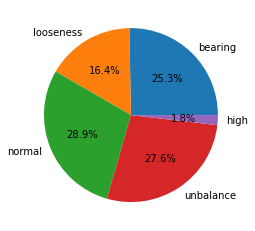

In [72]:
bearing = train_1st_Bearing.shape[0]+train_2nd_Bearing.shape[0]
looseness = train_1st_Looseness.shape[0]+train_2nd_Looseness.shape[0]
normal = train_1st_Normal.shape[0] + train_3rd_Normal.shape[0]
unbalance = train_1st_Unbalance.shape[0] + train_2nd_Unbalance.shape[0] + train_3rd_Unbalance.shape[0]
high = train_1st_high.shape[0] 

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

### Dataset Construction/Augmentation and Solving Class Imabalance Problem

In [73]:
Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4 )
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 80)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 9)

100%|██████████| 487002/487002 [00:40<00:00, 12174.38it/s]


In [74]:
Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4 )
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 80)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 184373/184373 [00:14<00:00, 12756.83it/s]


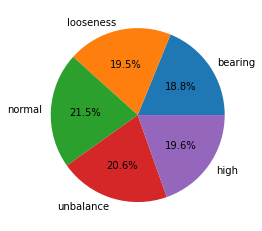

In [75]:
bearing = Bearing1st_ds.__len__().numpy() + Bearing2nd_ds.__len__().numpy()
looseness = Looseness1st_ds.__len__().numpy() + Looseness2nd_ds.__len__().numpy()
normal = Normal1st_ds.__len__().numpy() + Normal3rd_ds.__len__().numpy()
unbalance = Unbalance1st_ds.__len__().numpy() + Unbalance2nd_ds.__len__().numpy() + Unbalance3rd_ds.__len__().numpy()
high = High1st_ds.__len__().numpy()

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

In [76]:
batch_size = 128
Dataset = Bearing1st_ds.concatenate(Looseness1st_ds).concatenate(Normal1st_ds).concatenate(Unbalance1st_ds).concatenate(High1st_ds).concatenate(Bearing2nd_ds).concatenate(Looseness2nd_ds).concatenate(Unbalance2nd_ds).concatenate(Normal3rd_ds).concatenate(Unbalance3rd_ds).shuffle(buffer_size = 4518720, seed = 42).batch(batch_size).prefetch(1)

In [77]:
Dataset.__len__().numpy()

19427

In [78]:
Valid_Dataset = Dataset.take(15 * batch_size) 
Train_Dataset = Dataset.skip(15 * batch_size)
Train_Dataset = Dataset.take(135 * batch_size)

# VISUALIZATION

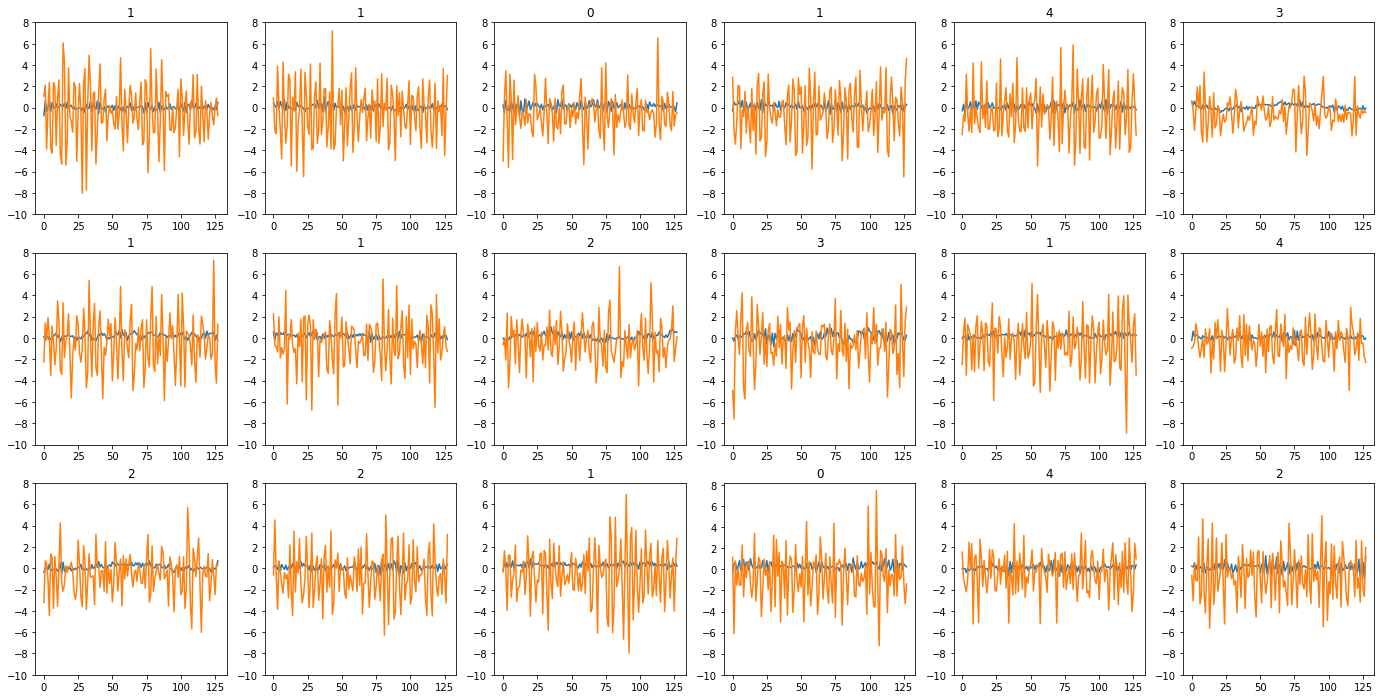

In [14]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(Dataset.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

# CUSTOM LAYER

In [79]:
class DynFeatures_RealFFT(keras.layers.Layer):
    def __init__(self):
      super(DynFeatures_RealFFT, self).__init__()

    def call(self, inputs):
      fft = tf.signal.fft(tf.cast(inputs, tf.complex64))
      return tf.math.real(fft)

class DynFeatures_ImagFFT(keras.layers.Layer):
    def __init__(self):
      super(DynFeatures_ImagFFT, self).__init__()

    def call(self, inputs):
      return tf.math.imag( tf.signal.fft(tf.cast(inputs, tf.complex64)))

class Statiscal_Analysis(keras.layers.Layer):
    # mean, min, max, RMS
    # Var, Skewness, Kurtosis
    # Shape Factor, Crest Factor, Impulse Factor
    def __init__(self, length_of_signal = 128):
      super(Statiscal_Analysis, self).__init__()
      self.length_of_signal = length_of_signal
    def call(self, inputs):
      mean = tf.reduce_mean(inputs,axis = 1)
      max = tf.reduce_max(inputs,axis = 1)
      min = tf.reduce_min(inputs,axis = 1)
      RMS = tf.math.sqrt(tf.reduce_mean(tf.math.exp(inputs),axis = 1))
      var = tf.math.reduce_variance(inputs,axis = 1)
      Skew = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),3),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),3)
      Kurto = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),4),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),4) 
      ShapeFactor = RMS*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      CrestFactor = tf.reduce_max(tf.abs(inputs),axis = 1)/RMS
      ImpulseFactor = tf.reduce_max(tf.abs(inputs),axis = 1)*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      # be aware of broadcasting
      return tf.concat([mean,max,min,RMS,var],axis = 1)

In [25]:
# Reference - https://www.kaggle.com/mistag/wavelet1d-custom-keras-wavelet-transform-layer/notebook

%%writefile tf_cwt.py
# Based on Alexander Neergaard Olesen's CWT Python implementation. https://github.com/neergaard/CWT
# Adapted to Keras by Geir Drange
# MIT License
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math

# tf.experimental.numpy.kron does not work on windows, use numpy.kron directly through a tf.numpy_function() wrapper
@tf.function
def kron(a, b):
    return tf.numpy_function(np.kron, [a, b], tf.complex64)

# calculate CWT of input signal
class Wavelet1D(keras.layers.Layer):
    def __init__(self, nv=12, sr=1., flow=0., fhigh=0.5, batch_size=None, trainable=False):
        super(Wavelet1D, self).__init__()
        assert fhigh > flow, 'fhigh parameters must be > flow!'
        assert batch_size != None, 'batch size must be set!'
        
        self.batch_size = batch_size 
        self.nv = nv # number of voices
        self.sr = sr # sample rate (Hz)
        self.flow = flow # lowest frequency of interest (Hz)
        self.fhigh = fhigh # highest frequency of interest (Hz)
        self.trainable = trainable # True to train the wavelet filter bank

    def build(self, input_shape):
        assert len(input_shape) == 2, 'Input dimension must be 2! Dimension is {}'.format(len(input_shape))
        
        max_scale = input_shape[-1] // (np.sqrt(2) * 2)
        if max_scale <= 1:
            max_scale = input_shape[-1] // 2
        max_scale = np.floor(self.nv * np.log2(max_scale))
        scales = 2 * (2**(1/self.nv)) ** np.arange(0, max_scale + 1)
        frequencies = self.sr * (6 / (2 * np.pi)) / scales
        frequencies = frequencies[frequencies >= self.flow] # remove low frequencies
        scales = scales[0:len(frequencies)]
        frequencies = frequencies[frequencies <= self.fhigh] # remove high frequencies
        scales = scales[len(scales)-len(frequencies):len(scales)]
        # wavft
        padvalue = input_shape[-1] // 2
        n = padvalue*2+input_shape[-1]
        omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
        omega = omega*(2 * np.pi) / n
        omega = np.concatenate((np.array([0]), omega, -omega[np.arange(math.floor((n - 1) / 2), 0, -1, dtype=int) - 1]))
        _wft = np.zeros([scales.size, omega.size])
        for jj, scale in enumerate(scales):
            expnt = -(scale * omega - 6) ** 2 / 2 * (omega > 0)
            _wft[jj, ] = 2 * np.exp(expnt) * (omega > 0)
        # parameters we want to use during call():
        self.wft = tf.Variable(_wft, trainable=self.trainable) # yes, the wavelets can be trainable if desired
        self.padvalue = padvalue
        self.num_scales = scales.shape[-1]
    
    # uses a loop - better to vectorize (TODO)
    def call(self, inputs):
        max_loop = tf.shape(inputs)[0]
        
        def sum_cwt(i, pre_data):
            next_data = tf.nn.embedding_lookup(inputs, i) 
            x = tf.concat([tf.reverse(next_data[0:self.padvalue], axis=[0]), next_data, tf.reverse(next_data[-self.padvalue:], axis=[0])], 0)
            f = tf.signal.fft(tf.cast(x, tf.complex64))
            cwtcfs = tf.signal.ifft(kron(tf.ones([self.num_scales, 1], dtype=tf.complex64), f) * tf.cast(self.wft, tf.complex64))
            logcwt = tf.math.log(tf.math.abs(cwtcfs[:, self.padvalue:self.padvalue + next_data.shape[-1]]))
            pre_data = tf.tensor_scatter_nd_add(pre_data, indices=[[i]], updates=[logcwt])
            i_next = i + 1
            return i_next, pre_data
                                 
        _, cwt = tf.while_loop(cond = lambda i, result: tf.less(i, max_loop),
                              body = sum_cwt,
                              loop_vars = (tf.constant(0, dtype=tf.int32), tf.zeros([self.batch_size, self.num_scales, inputs.shape[-1]], dtype = tf.float32)))
        return cwt

Overwriting tf_cwt.py


#### STFT

In [26]:
class FTHelper: 
    
    @staticmethod
    def build_conv_matrix(n_frames): 
        conv_matrix = tf.eye(n_frames)
        conv_matrix = tf.expand_dims(conv_matrix, 0)
        conv_matrix = tf.expand_dims(conv_matrix, -1)
        return conv_matrix

    @staticmethod
    def build_window(frame_length, window_type='hann'): 
        if window_type == 'hann': 
            weights = tf.signal.hann_window(frame_length)
            weights = tf.expand_dims(weights, -1)
            weights = tf.expand_dims(weights, -1)
            weights = tf.expand_dims(weights, 0)
            return tf.sqrt(weights)
        elif window_type == 'ones': 
            return tf.ones([1, frame_length, 1, 1])
        elif window_type == 'uniform': 
            return tf.random.uniform([1, frame_length, 1, 1], minval=0, maxval=1)
        elif window_type == 'random': 
            return tf.random.normal([1, frame_length, 1, 1])
        else: 
            # TODO: Raise error
            return 
    
    @staticmethod
    def build_frequencies(n_freq, freq_type='linspace'): 
        if freq_type == 'linspace': 
            return tf.linspace(0., 3.14, n_freq)
        elif freq_type == 'uniform': 
            return tf.random.uniform([n_freq], minval=0, maxval=3.14)
        else: 
            # TODO: Raise Error
            return 


class STFT(tf.keras.layers.Layer):

    def __init__(
        self, 
        frame_length, 
        frame_step, 
        n_freqs, 
        frequency_trainable=False, 
        window_trainable=False, 
        freq_type='linspace', 
        window_type='hann',
        out_module=True
    ):
        super(STFT, self).__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.n_freqs = n_freqs
        self.frequency_trainable = frequency_trainable
        self.window_trainable = window_trainable
        self.freq_type = freq_type
        self.window_type = window_type
        self.out_module = out_module
    
    def _call_frame_matrix(self):
        # Convolution2d Transpose
        frame_matrix = tf.squeeze(
            tf.nn.conv2d_transpose(
                input=self.conv_matrix, 
                filters=tf.square(self.window), 
                output_shape=(1, self.n_frames, self.n_y, 1),
                strides=[1, 1, self.frame_step, 1], 
                padding="VALID"
            )
        )
        # Padding
        to_pad = self.sequence_length - self.n_y
        frame_matrix = tf.pad(frame_matrix, tf.constant([[0, 0], [0, to_pad]]), 'CONSTANT')
        return frame_matrix
  
    def build(self, input_shape):
        self.sequence_length = input_shape[-1]
        self.n_frames = (self.sequence_length - self.frame_length) // self.frame_step
        self.n_y = (self.n_frames-1) * self.frame_step + self.frame_length
        self.conv_matrix = FTHelper.build_conv_matrix(self.n_frames)
        self.times = tf.range(self.sequence_length, dtype=tf.float32)
        self.window = tf.Variable(
            name='window', 
            initial_value=FTHelper.build_window(self.frame_length, self.window_type),
            trainable=self.window_trainable
        )
        self.frequencies = tf.Variable(
            name='frequencies',
            initial_value=FTHelper.build_frequencies(self.n_freqs, self.freq_type), 
            trainable=self.frequency_trainable
        )

    def call(self, inputs):
        frame_matrix = self._call_frame_matrix()
        frames = tf.multiply(
            tf.expand_dims(tf.transpose(frame_matrix), 0), 
            tf.expand_dims(inputs, -1), 
        )
        frames = tf.transpose(frames, perm=[0, 2, 1])
        # DFT Computations
        operands = tf.tensordot(self.times, self.frequencies, axes=0)
        w_real = tf.math.cos(-operands)
        w_im = tf.math.sin(-operands)
        y_real = tf.tensordot(frames, w_real, axes=1)
        y_im = tf.tensordot(frames, w_im, axes=1)
        if self.out_module: 
            y_mod = tf.add(tf.square(y_real), tf.square(y_im))
            return tf.expand_dims(tf.math.log(y_mod + 1) / 2, -1)
        else: 
            return tf.stack([y_real, y_im], axis=-1) / self.sequence_length

        
class STFTInverseShared(tf.keras.layers.Layer): 
    
    def __init__(self, stft_layer): 
        super(STFTInverseShared, self).__init__()
        self.stft_layer = stft_layer
        self.epsilon = 1e-10  # Regularizing parameter
        
    def build(self, input_shape):  
        assert self.stft_layer.built
    
    def call(self, inputs): 
        frame_matrix = self.stft_layer._call_frame_matrix()
        frame_matrix_t = tf.transpose(frame_matrix)
        y_real = inputs[:, :, :, 0]
        y_im = inputs[:, :, :, 1]
        operands = tf.tensordot(self.stft_layer.times, self.stft_layer.frequencies, axes=0)
        v_real = tf.math.cos(operands)
        v_im = tf.math.sin(operands)
        y_real_t = tf.transpose(y_real, [2, 0, 1])
        y_im_t = tf.transpose(y_im, [2, 0, 1])
        x_real = (tf.tensordot(v_real, y_real_t, axes=1) - tf.tensordot(v_im, y_im_t, axes=1))
        x_im = (tf.tensordot(v_im, y_real_t, axes=1) + tf.tensordot(v_real, y_im_t, axes=1))
        x_real_t = tf.transpose(x_real, [1, 0, 2])
        x_real_ts = tf.reduce_sum(x_real_t * frame_matrix_t, axis=2) / (tf.reduce_mean(frame_matrix_t, axis=1) + self.epsilon)
        return x_real_ts 
        

class STFTInverse(tf.keras.layers.Layer): 
    
    def __init__(
        self, 
        frame_length, 
        frame_step, 
        frequency_trainable=False, 
        window_trainable=False,
        freq_type='linspace', 
        window_type='hann'
    ): 
        super(STFTInverse, self).__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.frequency_trainable = frequency_trainable
        self.window_trainable = window_trainable
        self.freq_type = freq_type
        self.window_type = window_type
    
    def _call_frame_matrix(self):
        # Convolution2d Transpose
        frame_matrix = tf.squeeze(
            tf.nn.conv2d_transpose(
                input=self.conv_matrix, 
                filters=tf.square(self.window), 
                output_shape=(1, self.n_frames, self.n_y, 1),
                strides=[1, 1, self.frame_step, 1], 
                padding="VALID"
            )
        )
        # Padding
        to_pad = self.sequence_length - self.n_y
        frame_matrix = tf.pad(frame_matrix, tf.constant([[0, 0], [0, to_pad]]), 'CONSTANT')
        return frame_matrix
    
    def build(self, input_shape): 
        # Shapes
        self.n_frames = input_shape[-3]
        self.n_freqs = input_shape[-2]
        self.sequence_length = self.n_frames * self.frame_step + self.frame_length + 1
        self.n_y = (self.n_frames-1) * self.frame_step + self.frame_length
        assert input_shape[-1] == 2, 'Last dim must be two (Real / Imaginary)'
        # Not Trainable
        self.times = tf.range(self.sequence_length, dtype=tf.float32)
        self.conv_matrix = FTHelper.build_conv_matrix(self.n_frames)
        # Trainable
        self.window = tf.Variable(
            name='window', 
            initial_value=FTHelper.build_window(self.frame_length, self.window_type), 
            trainable=self.window_trainable)
        self.frequencies = tf.Variable(
            name='frequencies',
            initial_value=FTHelper.build_frequencies(self.n_freqs, self.freq_type), 
            trainable=self.frequency_trainable)
    
    def call(self, inputs): 
        frame_matrix = self._call_frame_matrix()
        frame_matrix_t = tf.transpose(frame_matrix)
        y_real = inputs[:, :, :, 0]
        y_im = inputs[:, :, :, 1]
        operands = tf.tensordot(self.times, self.frequencies, axes=0)
        v_real = tf.math.cos(operands)
        v_im = tf.math.sin(operands)
        y_real_t = tf.transpose(y_real, [2, 0, 1])
        y_im_t = tf.transpose(y_im, [2, 0, 1])
        x_real = (tf.tensordot(v_real, y_real_t, axes=1) - tf.tensordot(v_im, y_im_t, axes=1))
        x_im = (tf.tensordot(v_im, y_real_t, axes=1) + tf.tensordot(v_real, y_im_t, axes=1))
        epsilon = 1e-10  # Regularizing parameter
        x_real_t = tf.transpose(x_real, [1, 0, 2])
        x_real_ts = tf.reduce_sum(x_real_t * frame_matrix_t, axis=2) / (tf.reduce_mean(frame_matrix_t, axis=1) + epsilon)
        return x_real_ts 

#Convolutional LSTM

### Original Model

In [27]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
),
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)]

In [ ]:
model35 = keras.models.Sequential([ 
        keras.layers.InputLayer(input_shape=(128,2)),
        keras.layers.Conv1D(72, 10, padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(72, 10, padding = 'same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size = 2),
        keras.layers.Activation('elu'),
        keras.layers.Conv1D(36, 10, padding = 'same' ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(36, 10, padding = 'same' ),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool1D(pool_size = 2),
        keras.layers.Activation('elu'),
        keras.layers.LSTM(50),
        keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units = 5, activation = 'softmax'),
])
model35.summary()
model35.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist1 = model35.fit(Train_Dataset, epochs = 50, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 72)           1512      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 72)           288       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 72)           51912     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 72)           288       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 72)            0         
_________________________________________________________________
activation (Activation)      (None, 64, 72)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 36)            2

KeyboardInterrupt: ignored

### CLSTM Without CWT

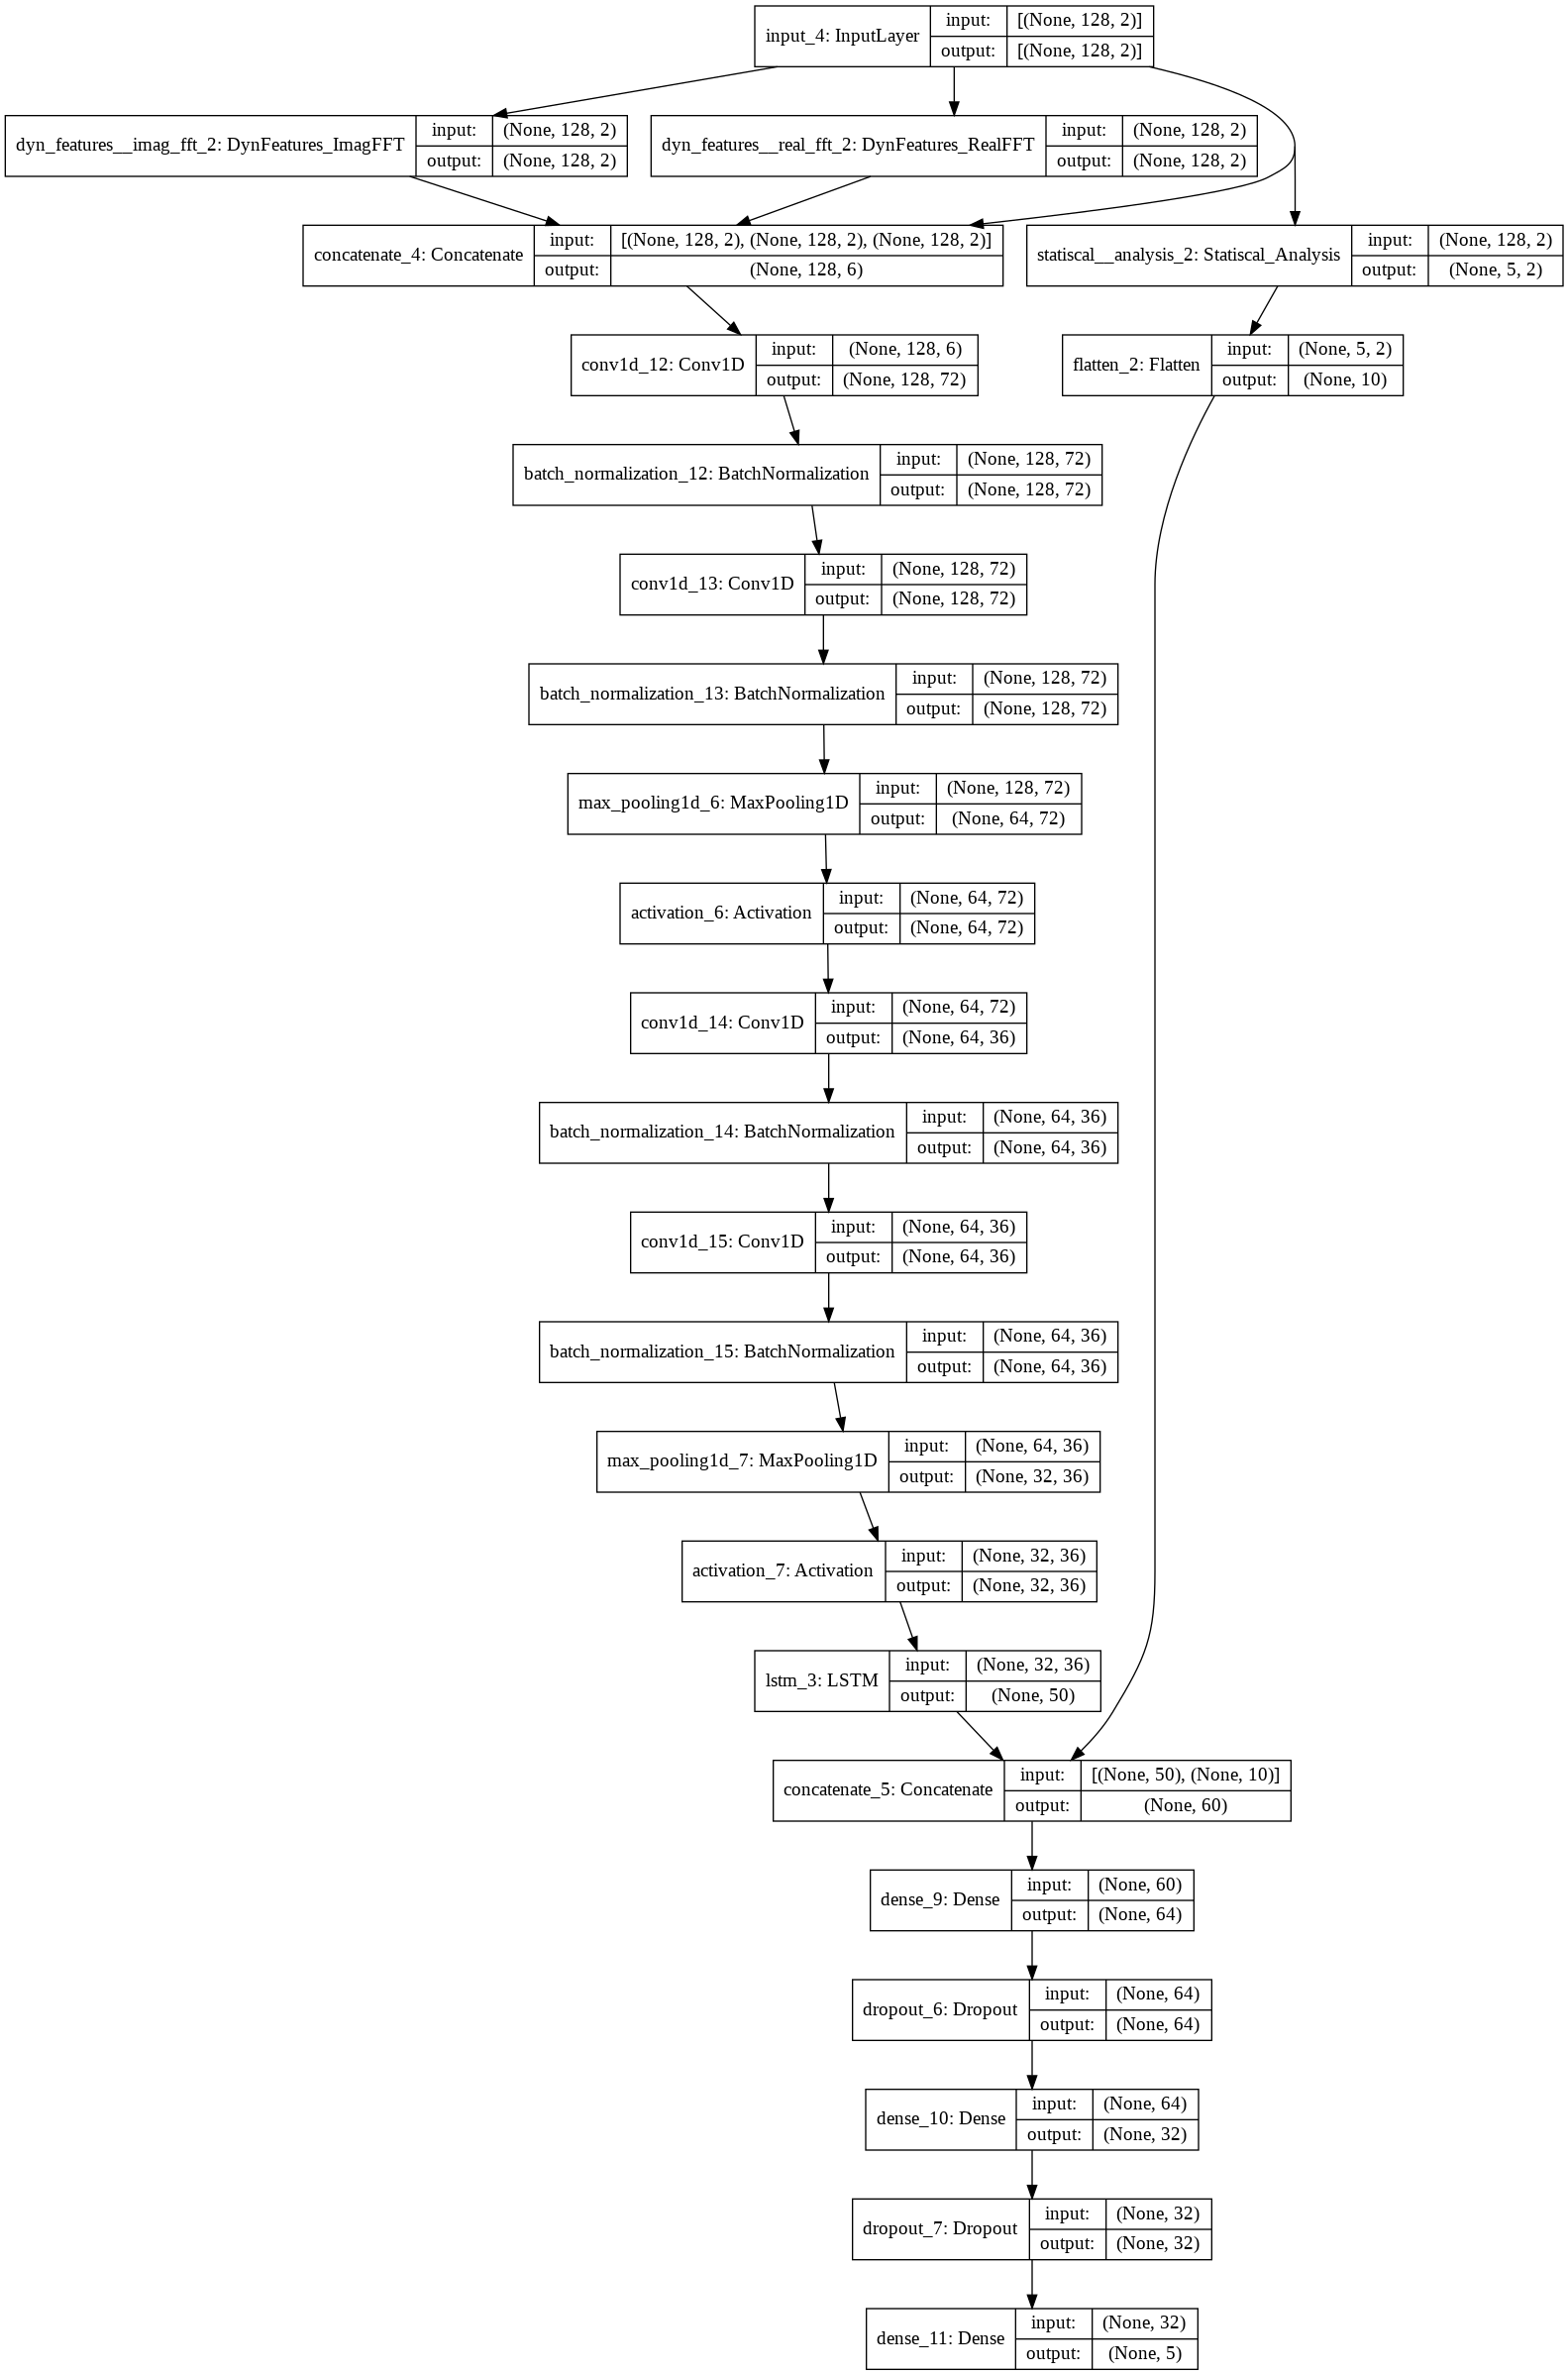

In [ ]:
def Convolutional_LSTM_WITHOUT_CWT(kernel = 72, CWT_Freq = 4, kernel_size= 10):
  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  Dynamic_Features = keras.layers.Concatenate()([i,r,inputs])
  Statistical_Features = Statiscal_Analysis(length_of_signal=128)(inputs)
  Statistical_Features = keras.layers.Flatten()(Statistical_Features)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(Dynamic_Features)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.LSTM(50)(x)
  x = keras.layers.Concatenate()([x, Statistical_Features])
  x = keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model
CLSTM_WITHOUT_CWT = Convolutional_LSTM_WITHOUT_CWT()
keras.utils.plot_model(CLSTM_WITHOUT_CWT, show_shapes=True)

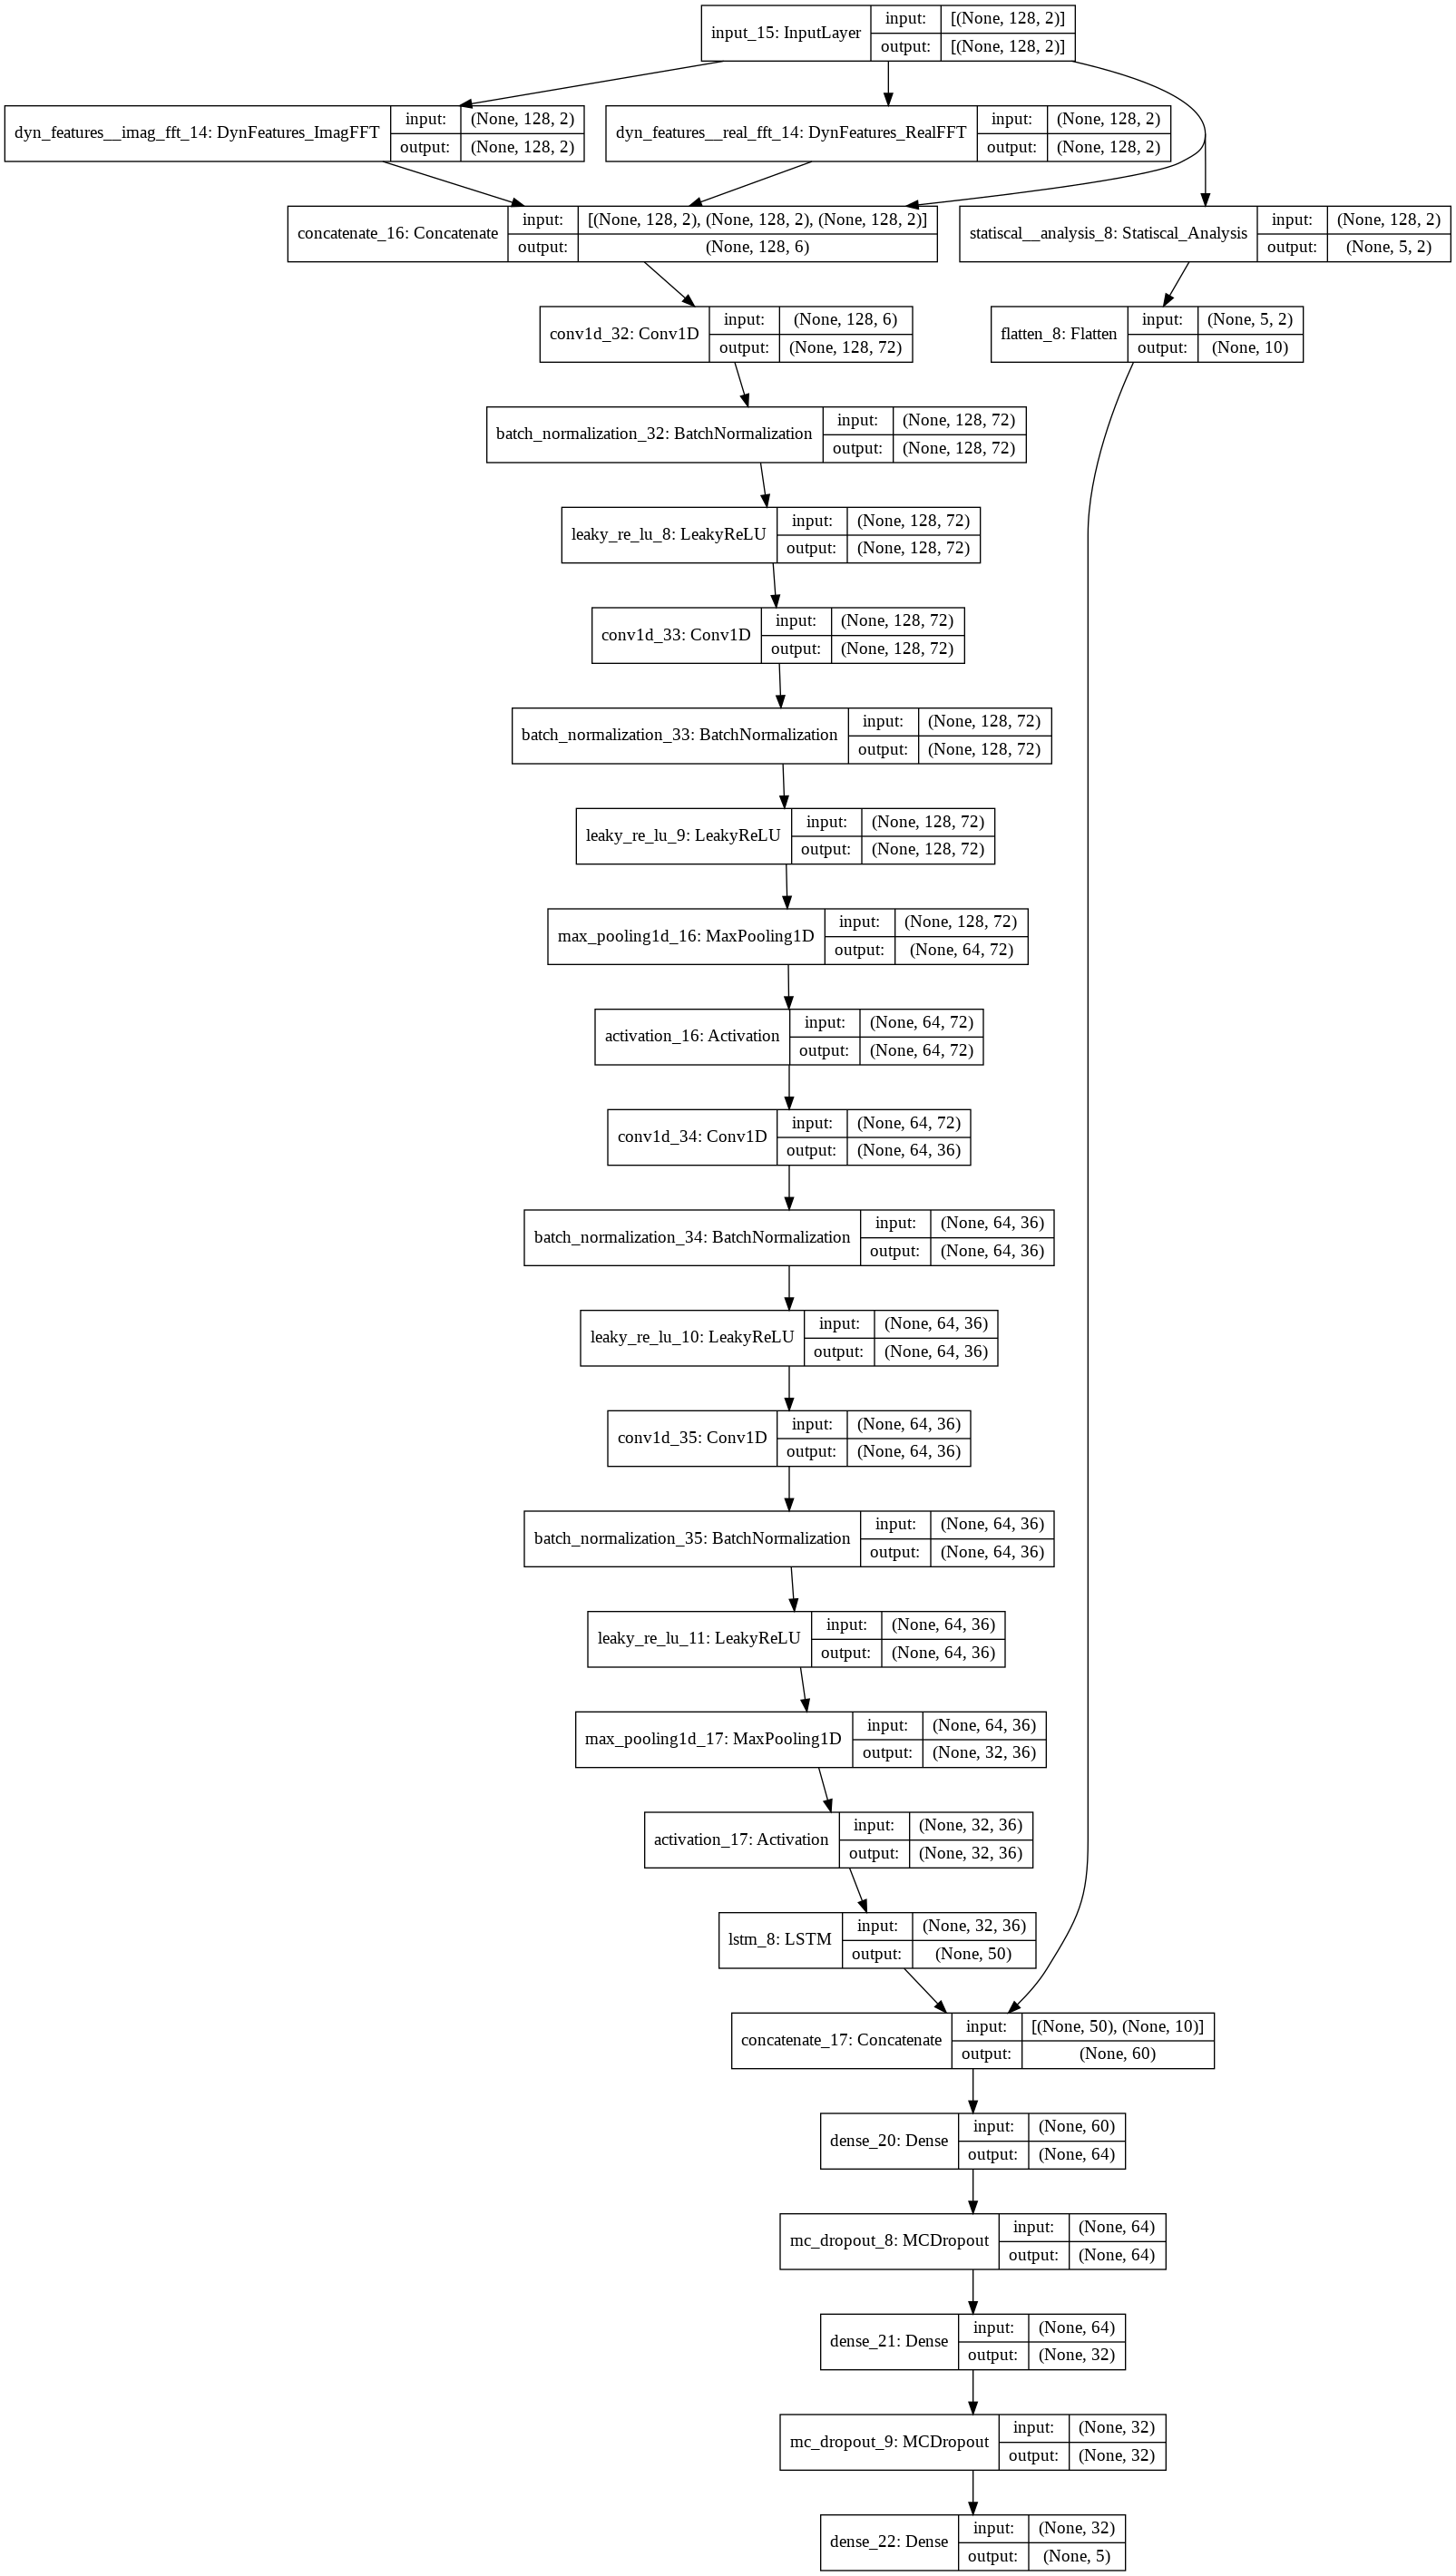

In [62]:
def Convolutional_LSTM_WITHOUT_CWT_new(kernel = 72, CWT_Freq = 4, kernel_size= 10):
  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  Dynamic_Features = keras.layers.Concatenate()([i,r,inputs])
  Statistical_Features = Statiscal_Analysis(length_of_signal=128)(inputs)
  Statistical_Features = keras.layers.Flatten()(Statistical_Features)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(Dynamic_Features)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.LSTM(50)(x)
  x = keras.layers.Concatenate()([x, Statistical_Features])
  x = keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = MCDropout(0.5)(x)
  x = keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = MCDropout(0.5)(x)
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model
CLSTM_WITHOUT_CWT_new = Convolutional_LSTM_WITHOUT_CWT_new()
keras.utils.plot_model(CLSTM_WITHOUT_CWT_new, show_shapes=True)


In [ ]:
CLSTM_WITHOUT_CWT.summary()
CLSTM_WITHOUT_CWT.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist2 = CLSTM_WITHOUT_CWT.fit(Train_Dataset, epochs = 2, shuffle = True, validation_data = Valid_Dataset,
                      callbacks = callbacks)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
dyn_features__imag_fft_2 (DynFe (None, 128, 2)       0           input_4[0][0]                    
__________________________________________________________________________________________________
dyn_features__real_fft_2 (DynFe (None, 128, 2)       0           input_4[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 128, 6)       0           dyn_features__imag_fft_2[0][0]   
                                                                 dyn_features__real_fft_2[0]

In [63]:
CLSTM_WITHOUT_CWT_new.summary()
CLSTM_WITHOUT_CWT_new.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist2 = CLSTM_WITHOUT_CWT_new.fit(Train_Dataset, epochs = 2, shuffle = True, validation_data = Valid_Dataset,
                      callbacks = callbacks)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
dyn_features__imag_fft_14 (DynF (None, 128, 2)       0           input_15[0][0]                   
__________________________________________________________________________________________________
dyn_features__real_fft_14 (DynF (None, 128, 2)       0           input_15[0][0]                   
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 128, 6)       0           dyn_features__imag_fft_14[0][0]  
                                                                 dyn_features__real_fft_14[0

### CLSTM Completed

In [80]:
from tf_cwt import Wavelet1D

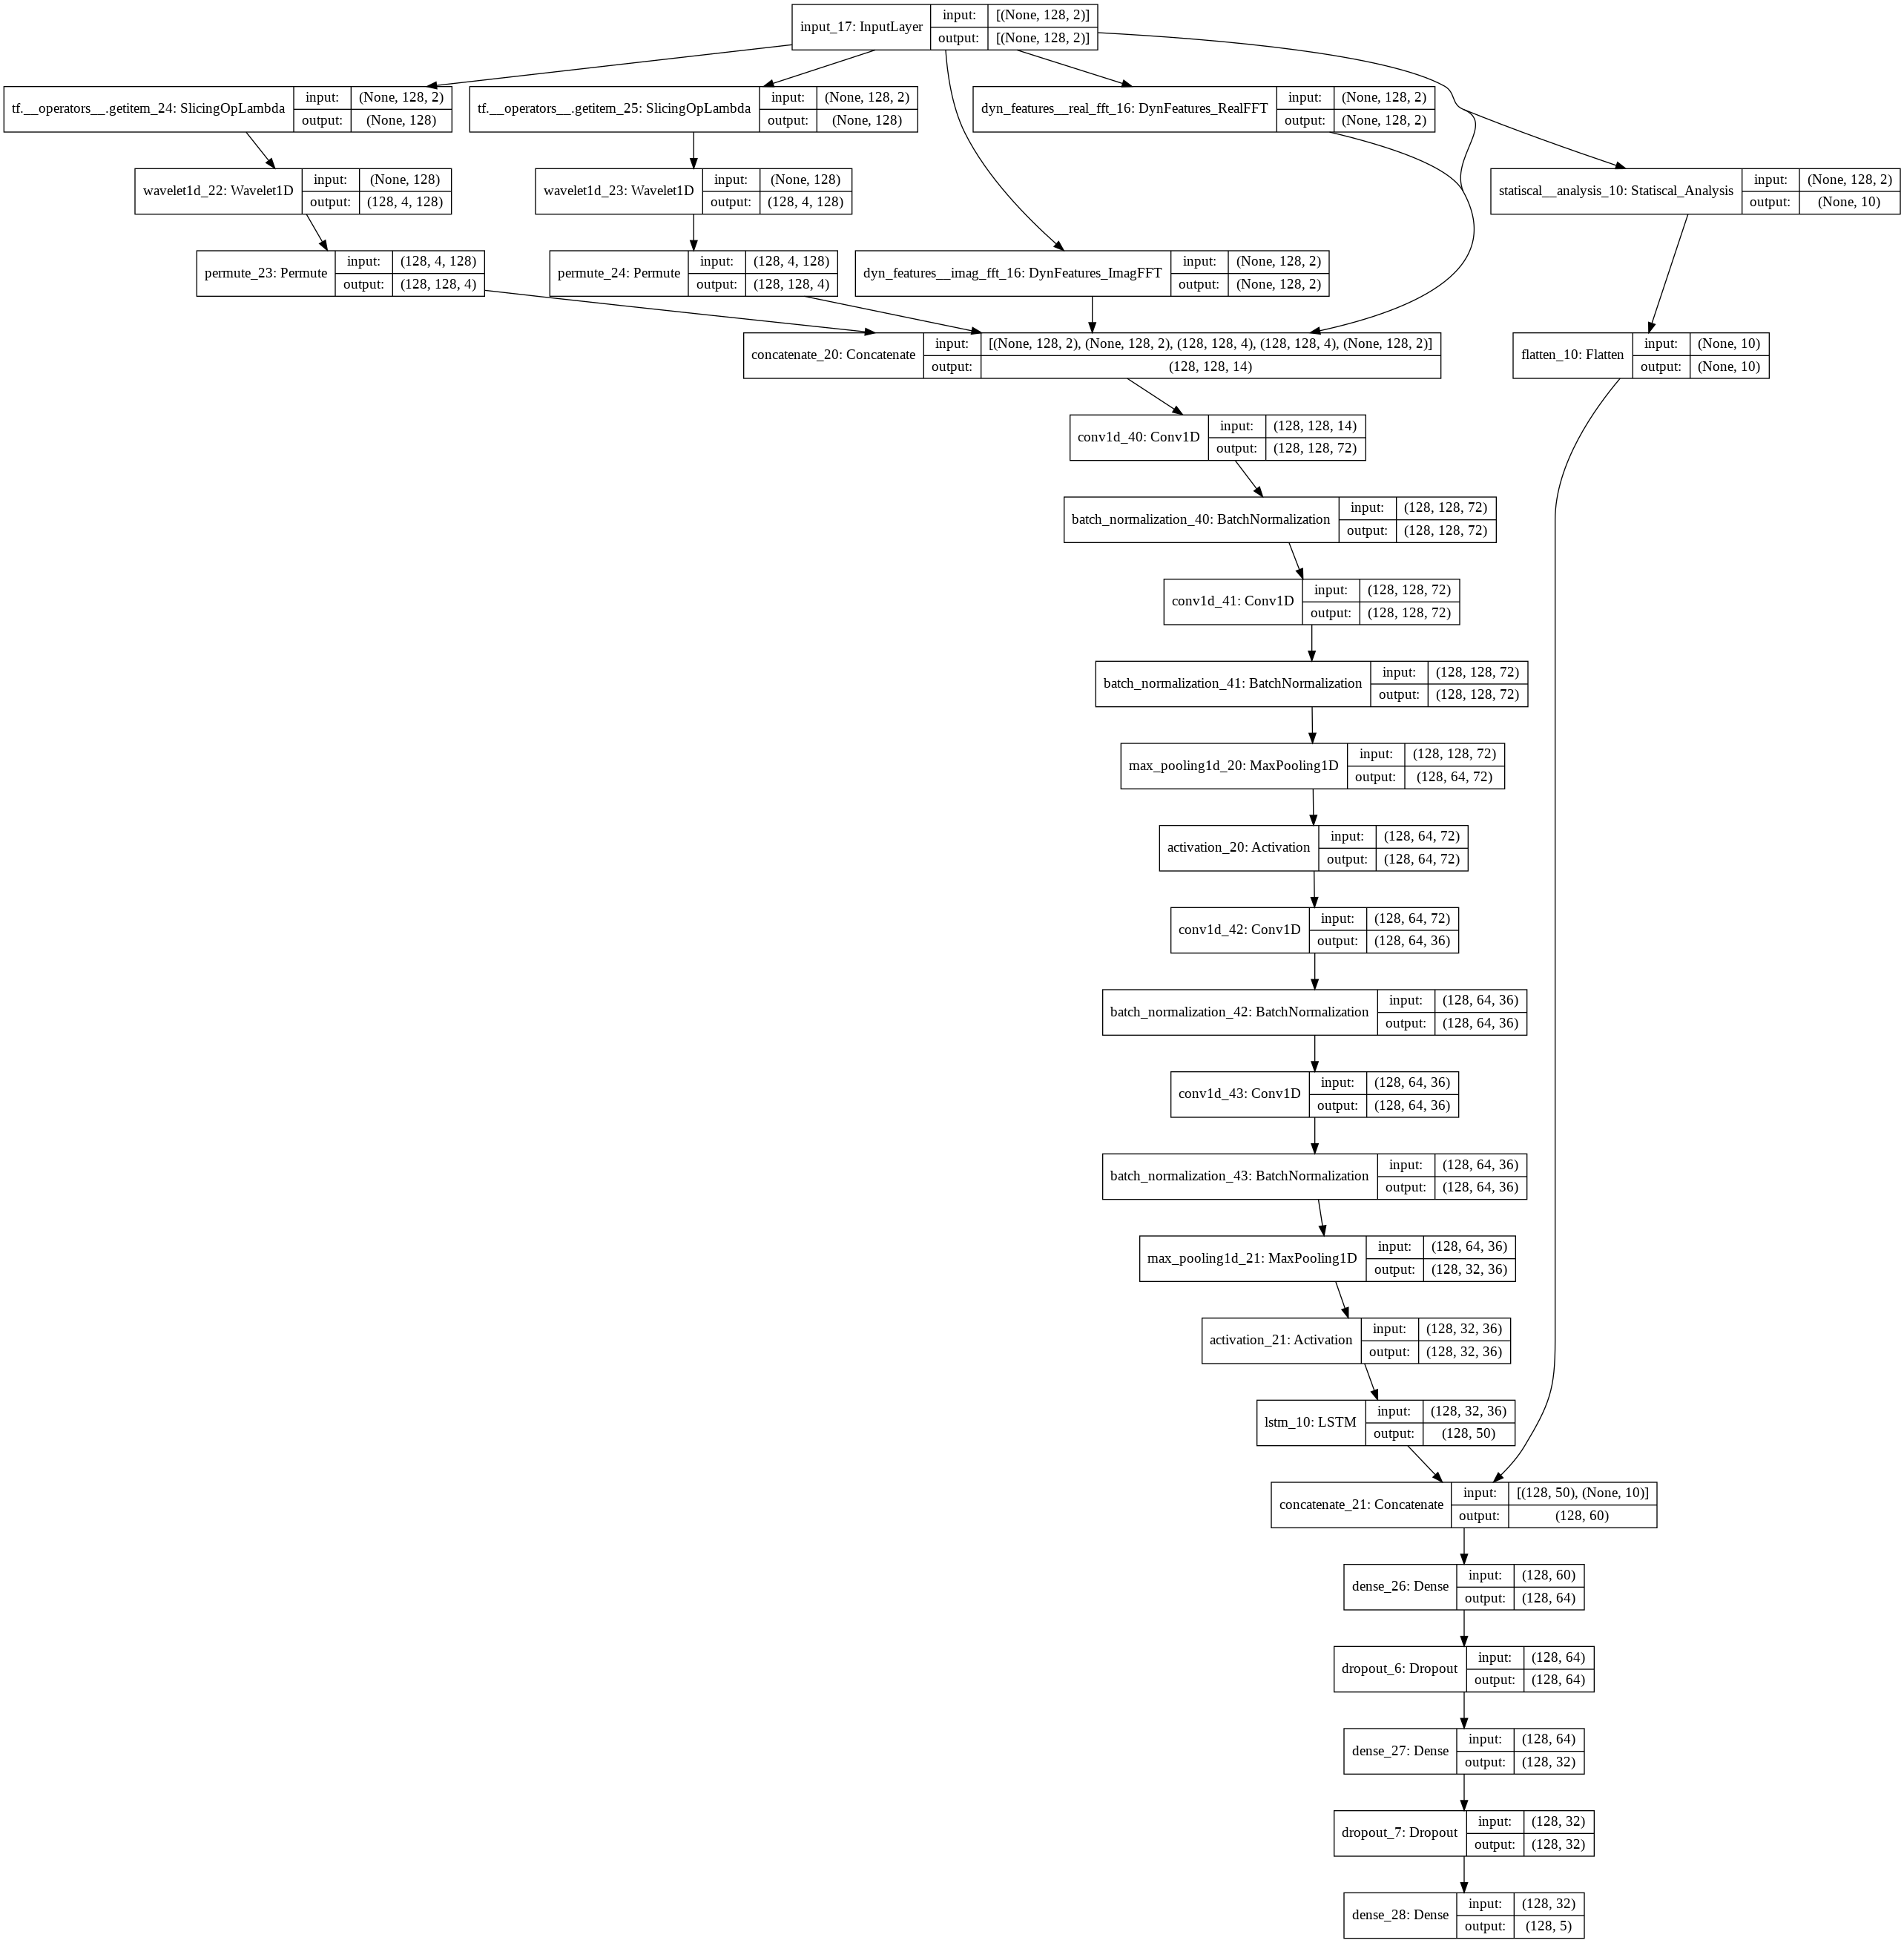

In [81]:
def Convolutional_LSTM(kernel = 72, CWT_Freq = 4, kernel_size= 5):
  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  c1 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,0])
  c1 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c1)
  c2 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,1])
  c2 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c2)
  Dynamic_Features = keras.layers.Concatenate()([i,r,c1,c2,inputs])
  Statistical_Features = Statiscal_Analysis(length_of_signal=128)(inputs)
  Statistical_Features = keras.layers.Flatten()(Statistical_Features)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(Dynamic_Features)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.LSTM(50)(x)
  x = keras.layers.Concatenate()([x, Statistical_Features])
  x = keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model
CLSTM = Convolutional_LSTM()
keras.utils.plot_model(CLSTM, show_shapes=True)

# **Homework**

In [35]:
class MCDropout(keras.layers.Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)

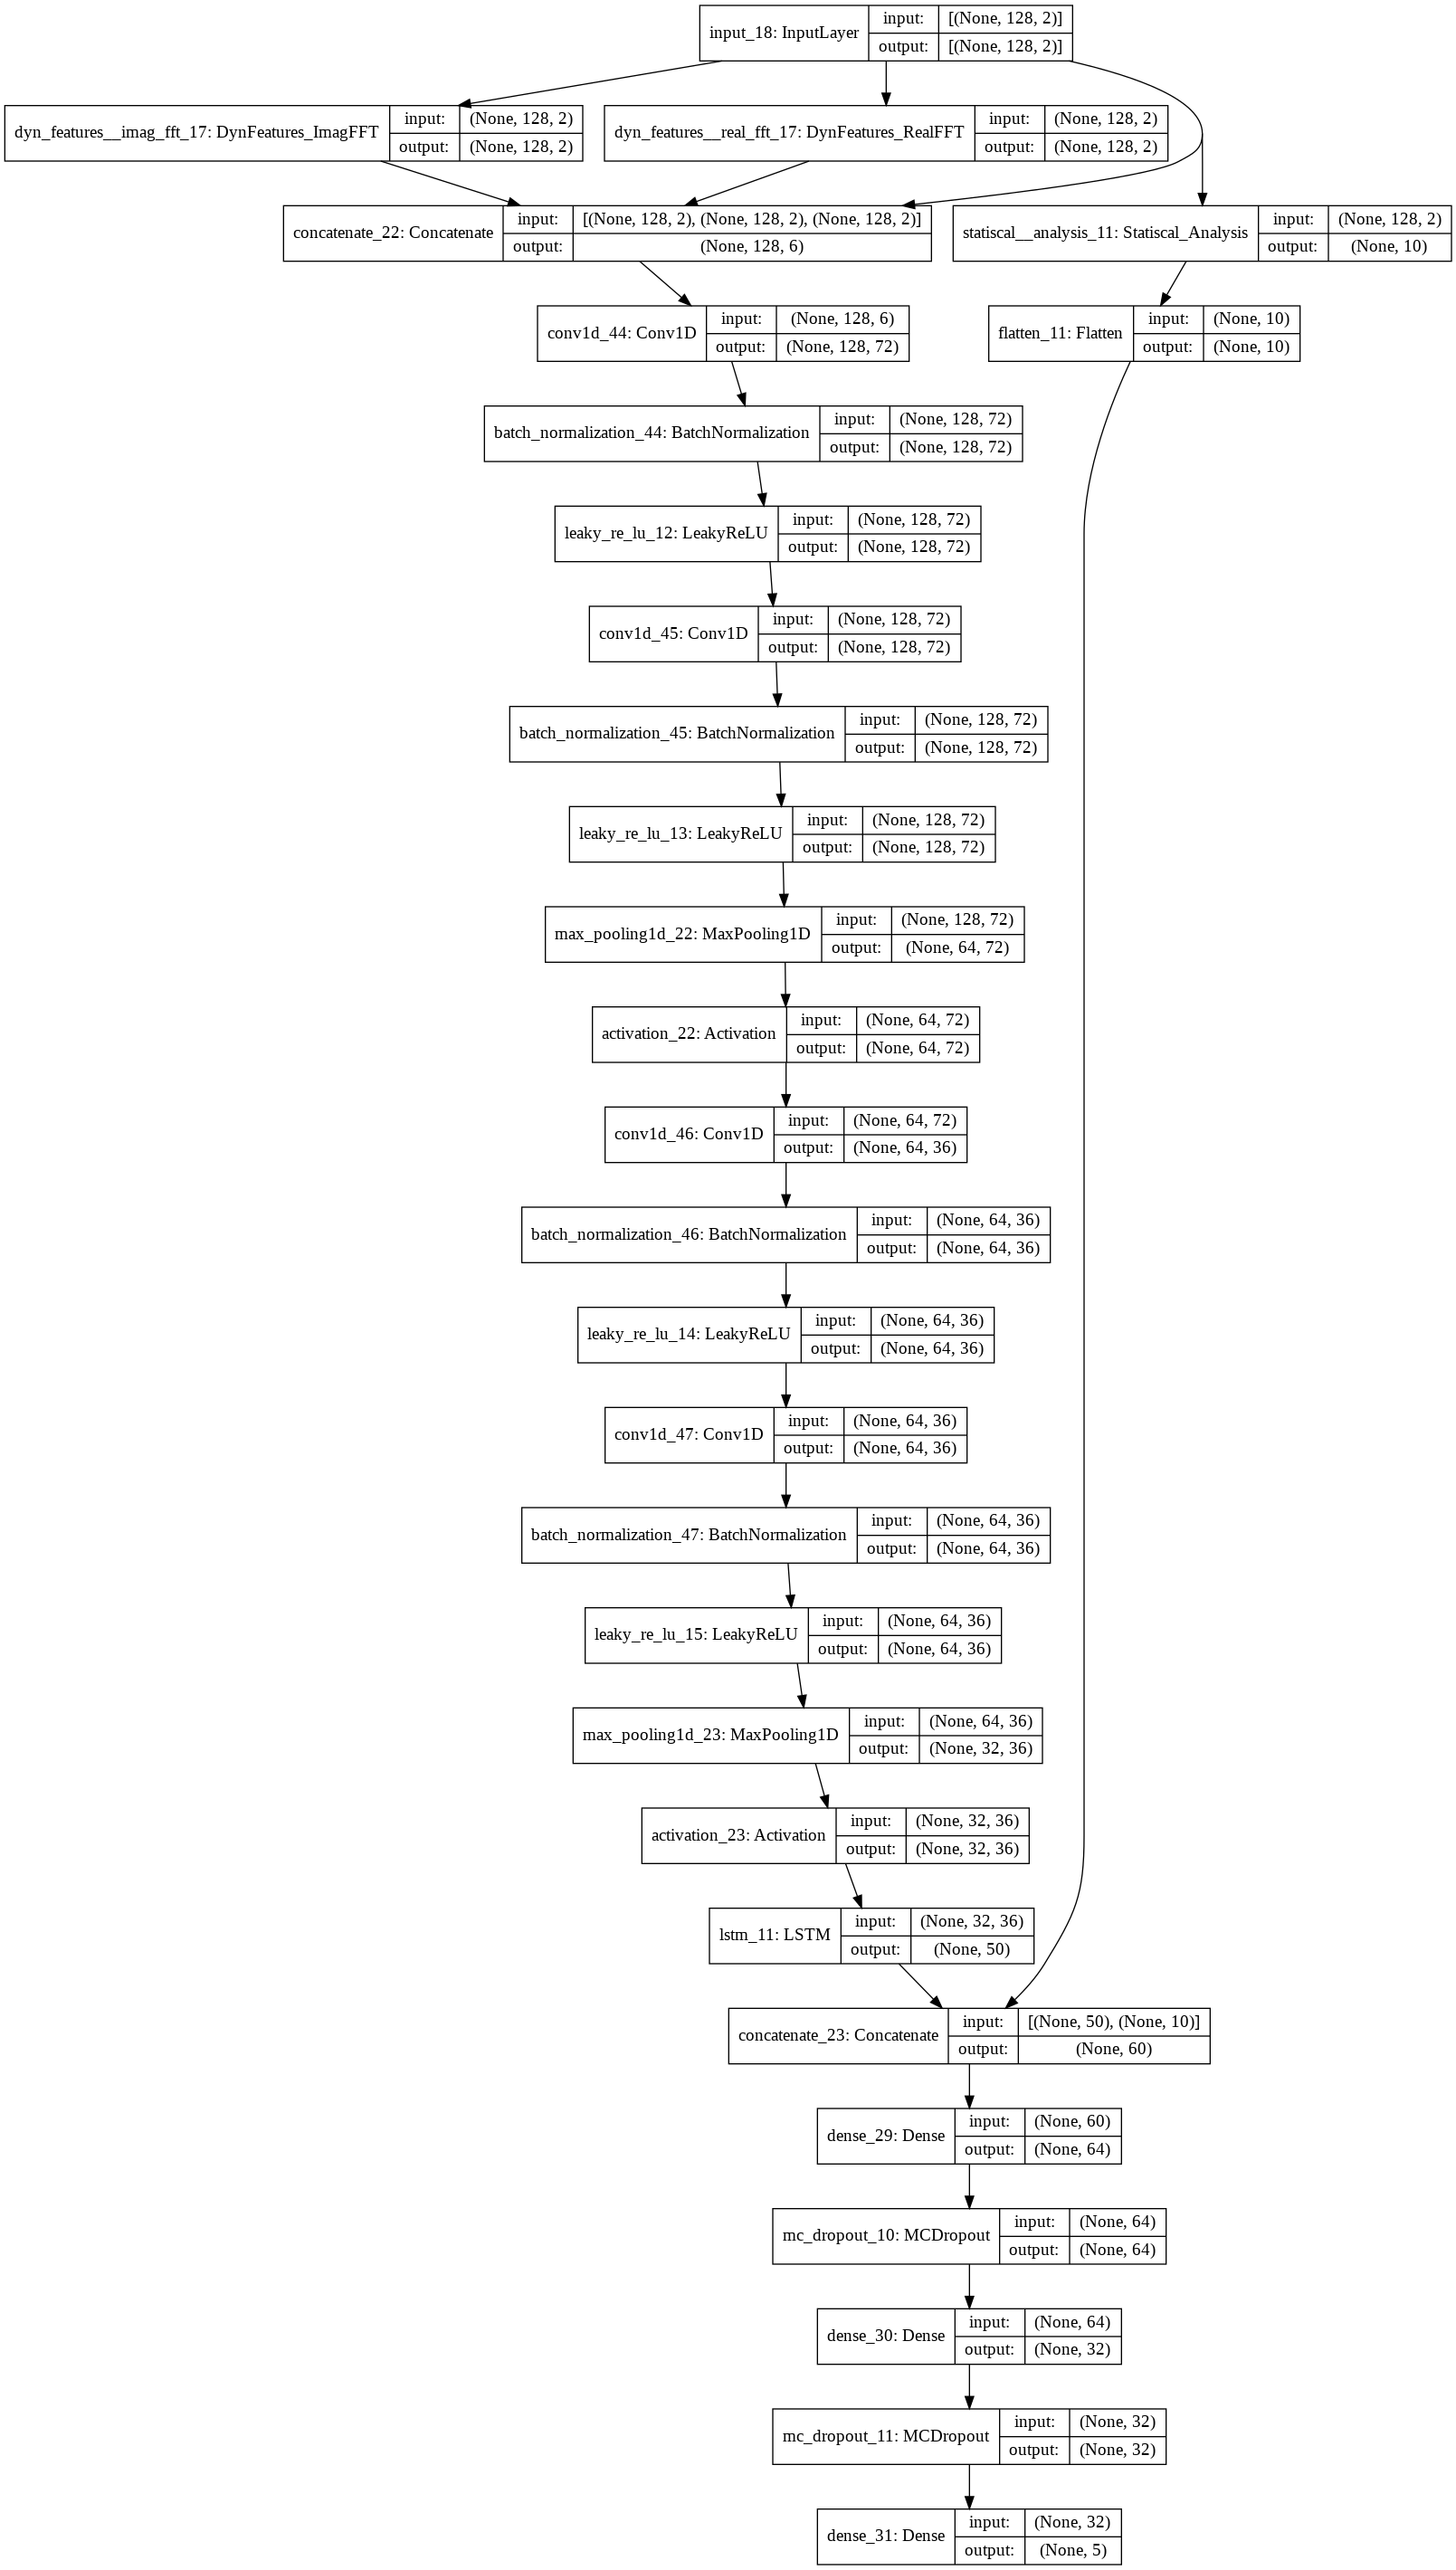

In [86]:
def Convolutional_LSTM_WITHOUT_CWT_new():
  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  Dynamic_Features = keras.layers.Concatenate()([i,r,inputs])
  Statistical_Features = Statiscal_Analysis(length_of_signal=128)(inputs)
  Statistical_Features = keras.layers.Flatten()(Statistical_Features)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(Dynamic_Features)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.LSTM(50)(x)
  x = keras.layers.Concatenate()([x, Statistical_Features])
  x = keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = MCDropout(0.5)(x)
  x = keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal')(x)
  x = MCDropout(0.5)(x)
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model
CLSTM_WITHOUT_CWT_new = Convolutional_LSTM_WITHOUT_CWT_new()
keras.utils.plot_model(CLSTM_WITHOUT_CWT_new, show_shapes=True)

In [ ]:
def Convolutional_LSTM_new(kernel = 72, CWT_Freq = 4, kernel_size= 5):
  inputs = keras.Input(shape = (128,2))
  i = DynFeatures_ImagFFT()(inputs)
  r = DynFeatures_RealFFT()(inputs)
  c1 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,0])
  c1 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c1)
  c2 = Wavelet1D(batch_size = 128, nv = 12,sr = 1, flow = 0.4, fhigh = 12800)(inputs[:,:,1])
  c2 = keras.layers.Permute((2,1), input_shape=(128,4,128))(c2)
  Dynamic_Features = keras.layers.Concatenate()([i,r,c1,c2,inputs])
  Statistical_Features = Statiscal_Analysis(length_of_signal=128)(inputs)
  Statistical_Features = keras.layers.Flatten()(Statistical_Features)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(Dynamic_Features)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.Conv1D(kernel, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.Conv1D(kernel/2, kernel_size, padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.MaxPool1D(pool_size = 2)(x)
  x = keras.layers.Activation('elu')(x)
  x = keras.layers.LSTM(50)(x)
  x = keras.layers.Concatenate()([x, Statistical_Features])
  x = keras.layers.Dense(units = 64, activation = 'elu', kernel_initializer = 'he_normal', kernel_constraint=tf.keras.constraints.max_norm(1.))(x)
  x = MCDropout(0.5)(x)
  x = keras.layers.Dense(units = 32, activation = 'elu', kernel_initializer = 'he_normal', kernel_constraint=tf.keras.constraints.max_norm(1.))(x)
  x = MCDropout(0.5)(x)
  outputs = keras.layers.Dense(units = 5, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  return model
CLSTM_new = Convolutional_LSTM_new()
keras.utils.plot_model(CLSTM_new, show_shapes=True)

In [87]:
CLSTM_WITHOUT_CWT_new.summary()
CLSTM_WITHOUT_CWT_new.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist3 = CLSTM_WITHOUT_CWT_new.fit(Train_Dataset, epochs = 5, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
dyn_features__imag_fft_17 (DynF (None, 128, 2)       0           input_18[0][0]                   
__________________________________________________________________________________________________
dyn_features__real_fft_17 (DynF (None, 128, 2)       0           input_18[0][0]                   
__________________________________________________________________________________________________
concatenate_22 (Concatenate)    (None, 128, 6)       0           dyn_features__imag_fft_17[0][0]  
                                                                 dyn_features__real_fft_17[0

In [44]:
CLSTM_new.summary()
CLSTM_new.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist4 = CLSTM_new.fit(Train_Dataset, epochs = 1, shuffle = True, validation_data = Valid_Dataset, callbacks = callbacks)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_20 (Sl (None, 128)          0           input_13[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_21 (Sl (None, 128)          0           input_13[0][0]                   
__________________________________________________________________________________________________
wavelet1d_18 (Wavelet1D)        (128, 4, 128)        1024        tf.__operators__.getitem_20[0][0]
____________________________________________________________________________________________

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
hist = hist4
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='rigth')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='left')

plt.show()

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
hist = hist1
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='center rigth')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='right')
plt.ylim([0.999,1])
plt.show()

In [ ]:
fig, loss_ax = plt.subplots()
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

acc_ax = loss_ax.twinx()
acc_ax.plot(hist1.history['val_acc'], 'g', label='val acc 1')
acc_ax.plot(hist2.history['val_acc'], 'r', label='val acc 2')
acc_ax.plot(hist3.history['val_acc'], 'b', label='val acc 3')
plt.show()

In [84]:
test_Dataset = test_Dataset.batch(128)

In [ ]:
pred=CLSTM_WITHOUT_CWT.predict(test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/model_CLSTM_WITHOUT_CWT.csv', index = False)
sub.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0dd7d72050>]],
      dtype=object)

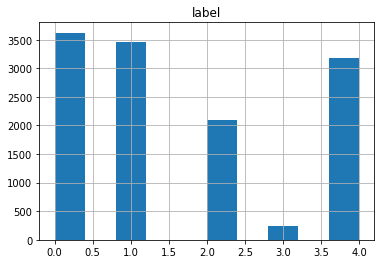

In [88]:
pred=CLSTM_WITHOUT_CWT_new.predict(test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/model_CLSTM_new1.csv', index = False)
sub.hist()